# Rev 스타일/기능 변경
- 색각이상 친화 팔레트 적용 (seaborn 'colorblind', matplotlib 'tab10'/'cividis').
- 범례 대비/가독성 강화 (배경/테두리/폰트).
- 저장 경로는 기존과 동일(`LaTeX/Figures/...`) 권장.



In [ ]:
# 전역 스타일 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_palette('colorblind')
except Exception:
    pass
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.get_cmap('tab10').colors)
mpl.rcParams['image.cmap'] = 'cividis'
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 13
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.fontsize'] = 10



In [1]:
import os
import time
import string

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

from tqdm import tqdm

# Font
from matplotlib import font_manager
font_path = "/workspace/fonts/"
font_list = os.listdir(font_path)
for font_file in font_list:
    try:
        font_manager.fontManager.addfont(font_path + font_file)
    except:
        raise Exception(f"Cannot Load {font_path+font_file}")

In [16]:
df = pd.read_csv('./Data_final/total_results_2048.csv', index_col=0)
df = df.sort_values('station name')

import geopandas as gpd

df_geo = gpd.read_file('/Data/Backup//Data/Geo/sido_20240213/ctp_rvn.shp', encoding='euc-kr')
geog = df_geo.to_crs(epsg=4326)


In [24]:
# Imports and paths
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

DATA_DIR = Path('Data')
MID_DIR = Path('Data_mid')
FINAL_DIR = Path('Data_final')
OUTPUT_DIR = Path('Output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_CLUSTERS = 3  # adjust if needed


In [25]:
# Station list from monthly files to ensure consistent naming
monthly_files = sorted([p for p in DATA_DIR.glob('Monthly_*.txt')])
stations = [p.stem.replace('Monthly_', '') for p in monthly_files]
len(stations), stations[:5]  # quick peek


(21, ['Anheung', 'Boryeong', 'Busan', 'Chujado', 'Gadeokdo'])

In [35]:
# Load station coordinates from total_results.csv (assumes columns: station name, latitude, longitude)
meta = pd.read_csv(FINAL_DIR / 'total_results_2048_0.6.csv')
meta = meta.rename(columns={
    'station name':'station', 'Station name':'station',
    'Latitude':'latitude','Longitude':'longitude'
})
coords = meta[['station','latitude','longitude']].dropna()
coords = coords[coords['station'].isin(stations)]
coords.shape, coords.head()


((21, 3),
     station   latitude   longitude
 0   Anheung  36.673611  126.132222
 1  Boryeong  36.406389  126.486111
 2     Busan  35.096111  129.035556
 3   Chujado  33.961667  126.300278
 4  Gadeokdo  35.024722  128.810833)

In [36]:
def load_eemd_series(station: str) -> pd.DataFrame:
    p = MID_DIR / f'{station}_CEEMDAN_2048_0.6.parquet'
    if not p.exists():
        return None
    try:
        df = pd.read_parquet(p)
    except Exception as e:
        print('Failed to load', p, e)
        return None
    # Expect IMF_0, IMF_1, ... columns; keep only those
    imf_cols = [c for c in df.columns if str(c).startswith('IMF_')]
    return df[imf_cols]

def make_features(df: pd.DataFrame, mode: str) -> np.ndarray:
    # Build 1D time series according to mode
    if mode == 'imf1':
        if 'IMF_1' not in df.columns: return None
        x = df['IMF_1'].values
    elif mode == 'imf2':
        if 'IMF_2' not in df.columns: return None
        x = df['IMF_2'].values
    elif mode == 'imf3':
        if 'IMF_3' not in df.columns: return None
        x = df['IMF_3'].values
    elif mode == 'imf12':
        for c in ['IMF_1','IMF_2']:
            if c not in df.columns: return None
        x = (df['IMF_1'] + df['IMF_2']).values
    elif mode == 'imf23':
        for c in ['IMF_2','IMF_3']:
            if c not in df.columns: return None
        x = (df['IMF_2'] + df['IMF_3']).values
    elif mode == 'imf123':
        for c in ['IMF_1','IMF_2','IMF_3']:
            if c not in df.columns: return None
        x = (df['IMF_1'] + df['IMF_2'] + df['IMF_3']).values
    elif mode == 'all':
        x = (df.sum(axis=1)).values
    else:
        raise ValueError('unknown mode')
    # de-mean by first value as in main text
    if len(x) == 0 or np.isnan(x).all():
        return None
    return x - x[0]

def build_matrix(stations, mode: str):
    series = {}
    for s in stations:
        df = load_eemd_series(s)
        if df is None: continue
        x = make_features(df, mode)
        if x is None: continue
        series[s] = x
    # Align by truncating to min length across stations
    if not series: return None, []
    L = min(len(v) for v in series.values())
    names = sorted(series.keys())
    X = np.vstack([series[n][:L] for n in names])
    return X, names

def cluster_kmeans(X, n_clusters=N_CLUSTERS, seed=0):
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
    labels = km.fit_predict(X)
    return labels

def get_clusters_for_modes(stations, modes=('imf1', 'imf2', 'imf12', 'imf23', 'imf123', 'all')):
    out = {}
    ref_names = None
    for m in modes:
        X, names = build_matrix(stations, m)
        if X is None or X.shape[0] < N_CLUSTERS:
            out[m] = ([], [])
            continue
        labels = cluster_kmeans(X, N_CLUSTERS)
        out[m] = (names, labels, X)
        if ref_names is None: ref_names = names
    return out

clusters = get_clusters_for_modes(stations)
# {k: (len(v[0]), set(v[0])) for k,v in clusters.items()}


In [37]:
# Assemble plotting dataframe
plot_df = coords.copy()
for mode in ['imf1', 'imf2', 'imf12', 'imf23', 'imf123', 'all']:
    names, labels, X = clusters.get(mode, ([], [], []))
    lab_map = {n:int(l) for n,l in zip(names, labels)}
    plot_df[f'cluster_{mode}'] = plot_df['station'].map(lab_map)

plot_df.head()


,station,latitude,longitude,cluster_imf1,cluster_imf2,cluster_imf12,cluster_imf23,cluster_imf123,cluster_all
0,Anheung,36.673611,126.132222,2,0,2,2,2,2
1,Boryeong,36.406389,126.486111,1,0,2,2,2,2
2,Busan,35.096111,129.035556,0,0,0,0,0,0
3,Chujado,33.961667,126.300278,1,0,1,2,1,1
4,Gadeokdo,35.024722,128.810833,1,1,1,1,0,1


/tmp/ipykernel_113237/601884897.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


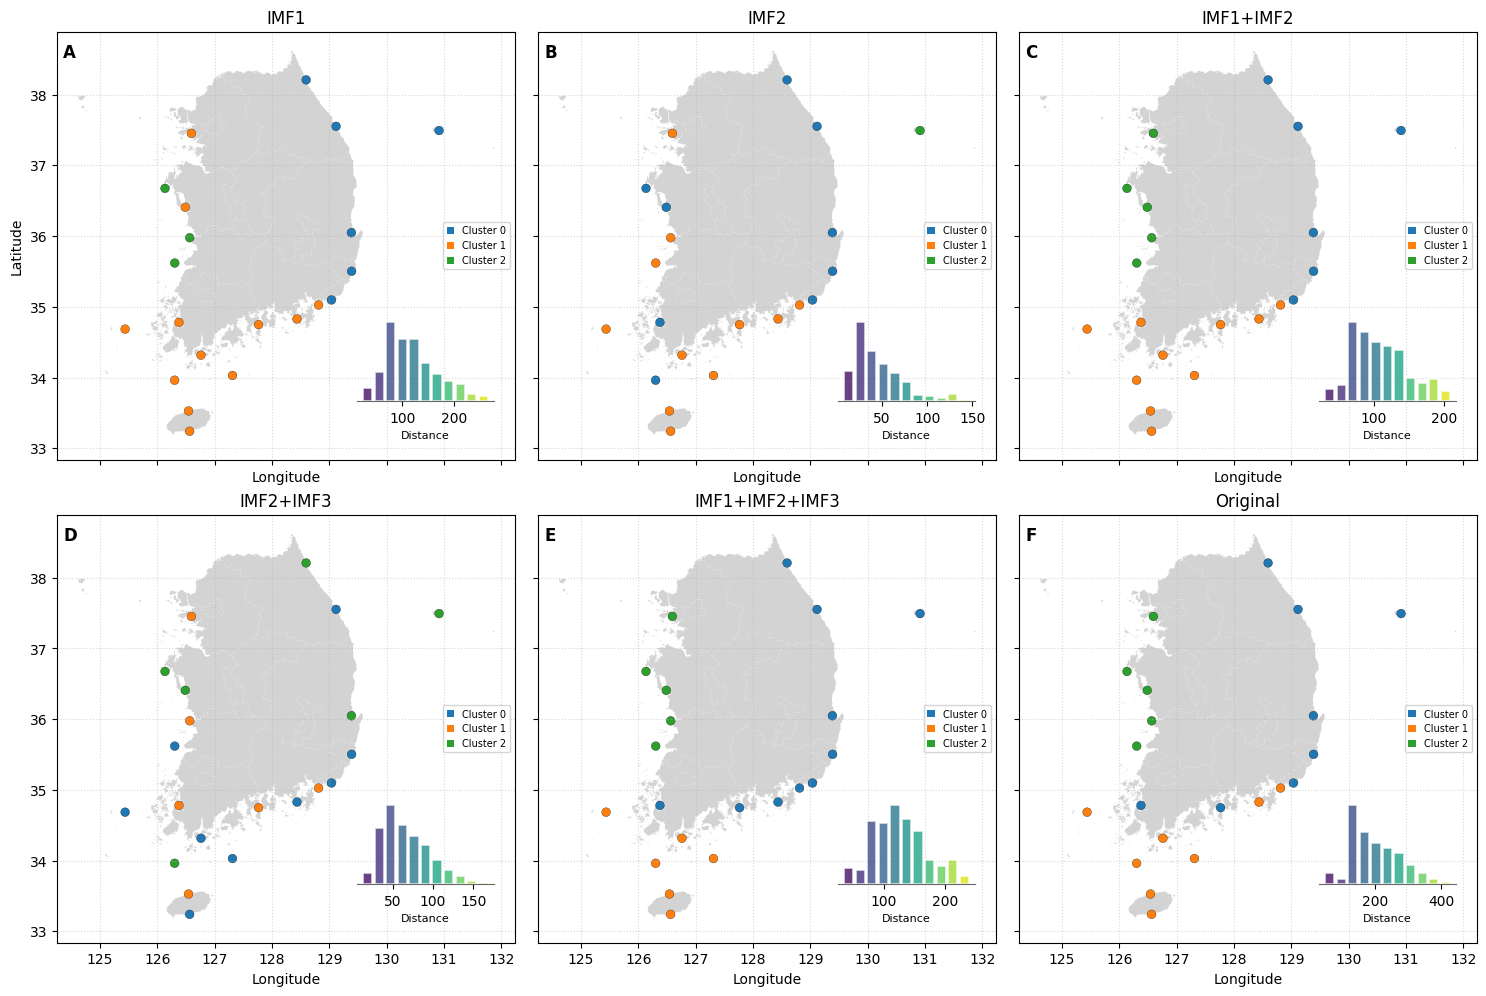

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# N_COL = 3
# N_ROW = 1

# fig = plt.figure(figsize=(12,4), dpi=300)
# spec = plt.GridSpec(ncols=N_COL, nrows=N_ROW, figure=fig)
# axes = []


modes = [('imf1','IMF1'), ('imf2','IMF2'), ('imf12','IMF1+IMF2'), ('imf23','IMF2+IMF3'), ('imf123','IMF1+IMF2+IMF3'), ('all','Original')]
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
for axi, (ax, (key, title)) in enumerate(zip(axes, modes)):
    ax.text(.014, .94, string.ascii_uppercase[axi], transform=ax.transAxes,
        size=12, weight='bold')

     # plot geo
    geog.plot(ax=ax, color='lightgrey', alpha=1.)
    col = f'cluster_{key}'
    dfp = plot_df.dropna(subset=[col])
    sc = ax.scatter(dfp['longitude'], dfp['latitude'], c=dfp[col].astype(int), cmap='tab10', vmin=0, vmax=10, s=40, edgecolor='k', linewidths=.2)

    from matplotlib.patches import Patch
    # 고유한 클러스터 값들과 개수 확인
    unique_clusters = sorted(set(dfp[col].astype(int)))
    n_clusters = len(unique_clusters)
    
    # tab10 colormap에서 색상 추출
    cmap = plt.cm.tab10
    colors = [cmap(i) for i in range(n_clusters)]
    
    # Legend elements 생성
    legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {cluster}') 
                       for i, cluster in enumerate(unique_clusters)]
    
    # Legend 추가
    ax.legend(handles=legend_elements, 
              loc='center right',  # 또는 원하는 위치
              fontsize=7, handlelength=.8
              # frameon=True,
              # fancybox=True,
              # shadow=True
             )

    
    ax.set_title(title)
    ax.grid(True, ls=':', alpha=.5)
    ax.set_xlabel('Longitude')


    # ── 여기서 subax 추가 ──
    # 메인 ax 기준으로 inset axes 생성 (조금 위로 이동)
    subax = inset_axes(ax,
                       width="30%",    # width = 30% of parent_bbox
                       height="30%",   # height = 30% of parent_bbox
                       loc='lower right',  # lower right -> upper right로 변경
                       bbox_to_anchor=(-.03, 0.12, 1, .65),  # (x0, y0, width, height)
                       bbox_transform=ax.transAxes,)
    
    # 히스토그램 데이터 준비
    from scipy.spatial.distance import pdist, squareform
    import numpy as np
    
    # X는 (n_samples, n_features) 형태
    X = clusters[key][2]
    dist = pdist(X, metric='euclidean').flatten()
    # r = corrs[axi]
    # bins = np.linspace(0, 500, 12)
    bins = np.linspace(min(dist), max(dist), 12)
    n, bins_edges, patches = subax.hist(dist,
                         bins=bins,
                         rwidth=0.8,
                         alpha=0.8,
                         edgecolor='white',
                         linewidth=1.2, zorder=2)
    
    # 그라디언트 색상 적용
    import matplotlib.colors as mcolors
    # norm = mcolors.Normalize(vmin=0, vmax=1)  # 실제 데이터 범위로 수정
    norm = mcolors.Normalize(vmin=min(dist), vmax=max(dist))  # 실제 데이터 범위로 수정
    cmap = plt.cm.viridis
    
    # 각 bin의 중앙값 계산
    bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
    
    # 패치 색상 설정
    for patch, center in zip(patches, bin_centers):
        patch.set_facecolor(cmap(norm(center)))
    
    # Threshold 선 추가
    # subax.axvline(THRESHOLD[axi], color='red', linestyle='--', linewidth=1, alpha=0.8, zorder=0)
    
    # # Threshold 값 텍스트 추가
    # subax.text(THRESHOLD[axi], max(n)*0.8, f'T={THRESHOLD[axi]:.2f}', 
    #            rotation=90, ha='right', va='top', 
    #            color='red', fontsize=8, fontweight='bold')
    
    # 스타일링
    subax.set_facecolor('none')
    for spine in ['top', 'right', 'left']:
        subax.spines[spine].set_visible(False)
    subax.spines['bottom'].set_color('#666666')
    
    # 라벨/틱 설정
    subax.set_xlabel('Distance', fontsize=8)
    subax.set_yticks([])
    # if axi == 1:
    #     subax.set_xticks(np.linspace(min(dist), max(dist), 5))
    # else:
    #     # 다른 패널들도 적절한 틱 설정
    #     tick_vals = np.linspace(min(dist), max(dist), 5)
    #     subax.set_xticks([round(x, 1) for x in tick_vals])
    
axes[0].set_ylabel('Latitude')
# fig.suptitle('Clustering by EEMD Components: IMF1, IMF2, IMF1+IMF2', y=1.02)
fig.tight_layout()
fig.savefig('LaTeX/Figures/Figure3_clustering.pdf', dpi=400, bbox_inches='tight')
plt.show()

